In [224]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
letters = ["A", "B", "C", "D"]
numers = ["1","2", "3", "4", "5", "6"]
keys = []
for letter in letters:
    for number in numers:
        keys.append(letter + number)

def cellcount(img):
    # plt.figure()
    # plt.imshow(img)
    # plt.show()
    th, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, img_thresh = cv2.threshold(img, th, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    minimum_area = 400
    average_cell_area = 1600
    connected_cell_area = 6400
    cells = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if area > minimum_area:
            cv2.drawContours(img, [c], -1, (255,255,255), 2)
            if area > connected_cell_area:
                cells += math.ceil(area / average_cell_area)
            else:
                cells += 1
    # plt.figure()
    # plt.imshow(close)
    # plt.imshow(img)
    # plt.show()
    return cells



In [225]:
import scipy.ndimage as im
import scipy.signal as sig

def gaussian_mask(sz=3, sigma=1/np.sqrt(2)):
    output = np.zeros([sz, sz])
    for i in range(sz):
        for j in range(sz):
            output[i,j] = np.exp(-0.5 * ((i - (sz - 1)/2)**2 + (j - (sz-1)/2)**2) / sigma ** 2)
    return output / np.sum(output)

def unsharp_mask(im, a, sz, sigma):
    S = im - sig.convolve2d(im, gaussian_mask(sz, sigma), "same")
    sharpened = im + a * S
    return np.min(np.array([np.max(np.array([sharpened, np.zeros_like(sharpened)]), axis=0), np.ones_like(sharpened) * 255]), axis=0)

def median_filter(image, sz=3):
    '''
    Applies median filter of size 3x3 without padding
    '''
    im_stacked = np.zeros([image.shape[0] - (sz-1), image.shape[1] - (sz - 1), sz**2])
    count = 0
    for n in range(sz):
        for m in range(sz):
            im_stacked[:,:,count] = image[0+n:image.shape[0] - (sz - 1) + n, 0+m:image.shape[1]-(sz-1) + m]
            count += 1
    output_im = np.median(im_stacked, axis=2)
    return output_im

In [226]:
cell_counts = {}

for key in keys:

    dapi = cv2.imread("GeneDelivery/{}_DAPI.jpg".format(key), cv2.IMREAD_GRAYSCALE)
    dapi = dapi - np.percentile(dapi.flatten(), 10)
    dapi = dapi / np.percentile(dapi.flatten(), 90) * 100
    dapi = median_filter(dapi)

    dapi = np.max(np.stack([dapi, np.zeros_like(dapi)], axis=0), axis=0).astype(np.uint8)

    gfp = cv2.imread("GeneDelivery/{}_GFP.jpg".format(key), cv2.IMREAD_GRAYSCALE)
    gfp = median_filter(gfp)
    gfp = gfp - np.percentile(gfp.flatten(), 10)
    gfp = np.max(np.stack([gfp, np.zeros_like(gfp)], axis=0), axis=0).astype(np.uint8)


    cells = cellcount(dapi)
    if gfp.max() < 10:
        trans_cells = 0
    else:
        th, gfp_mask = cv2.threshold(gfp, 10, 1, cv2.THRESH_BINARY)
        gfp_masked_dapi = dapi * gfp_mask
        trans_cells = cellcount(dapi * gfp_mask)
    cell_counts[key] = {"total":cells, "transfected":trans_cells}
    # hist, _ = np.histogram(gfp, np.arange(0, 255, 2))
    # plt.hist(gfp.flatten(), np.arange(0, 255, 2))
    # plt.show()

cell_counts = pd.DataFrame().from_dict(cell_counts)
cell_counts.to_csv("thing.csv")
cell_counts = cell_counts.transpose()
cell_counts

total  transfected
A1    471            0
A2    602            0
A3    626            0
A4    486           14
A5    526           21
A6    643           16
B1    560           16
B2    769           23
B3    539           15
B4    801          258
B5    938           74
B6    662           58
C1    681            0
C2    615            0
C3    629            0
C4    584            0
C5    519            0
C6    982            0
D1    631            0
D2    645            0
D3    720            0
D4    705          151
D5    640          110
D6    496          121

8.679050355512903


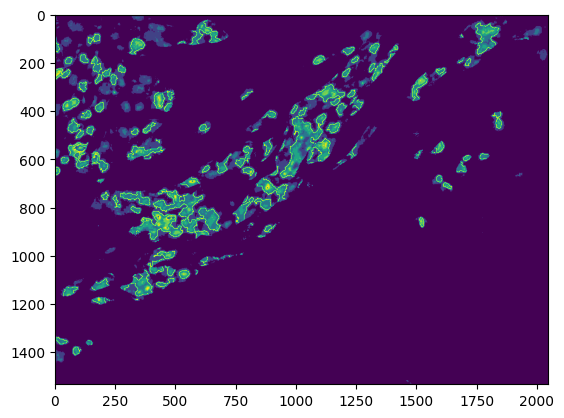

In [227]:
plt.imshow(dapi * gfp_mask)
print(np.mean(gfp))

In [229]:
cell_counts["efficacy"] = cell_counts["transfected"] / cell_counts["total"]
avg_control_cells = cell_counts.loc["C1", "total"]
cell_counts["viability"] = cell_counts["total"] / avg_control_cells
cell_counts

total  transfected  efficacy  viability
A1    471            0  0.000000   0.691630
A2    602            0  0.000000   0.883994
A3    626            0  0.000000   0.919236
A4    486           14  0.028807   0.713656
A5    526           21  0.039924   0.772394
A6    643           16  0.024883   0.944200
B1    560           16  0.028571   0.822320
B2    769           23  0.029909   1.129222
B3    539           15  0.027829   0.791483
B4    801          258  0.322097   1.176211
B5    938           74  0.078891   1.377386
B6    662           58  0.087613   0.972100
C1    681            0  0.000000   1.000000
C2    615            0  0.000000   0.903084
C3    629            0  0.000000   0.923642
C4    584            0  0.000000   0.857562
C5    519            0  0.000000   0.762115
C6    982            0  0.000000   1.441997
D1    631            0  0.000000   0.926579
D2    645            0  0.000000   0.947137
D3    720            0  0.000000   1.057269
D4    705          151  0.214184   1.035242
D5    640          110  0.171875   0.939794
D6    496          121  0.243952   0.728341

In [303]:
selected = cell_counts.loc[pbae_things]
selected.index = pbae_keys
selected

total  transfected  efficacy  viability
Untreated Cells    681            0  0.000000   1.000000
PBAE+NaAc          629            0  0.000000   0.923642
50                 705          151  0.214184   1.035242
75                 769           23  0.029909   1.129222
100                801          258  0.322097   1.176211

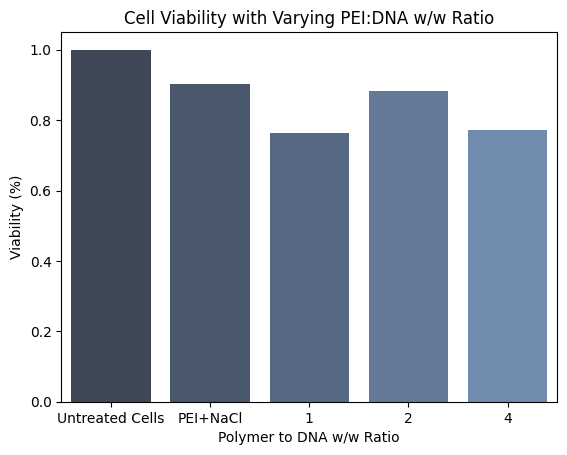

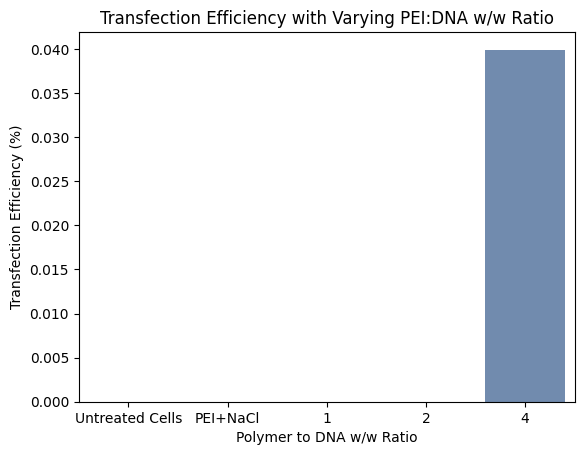

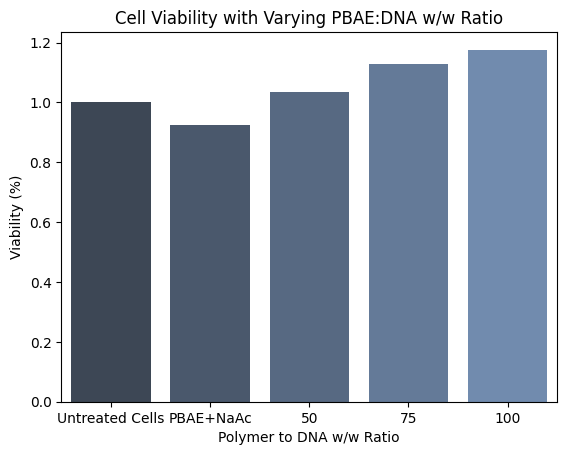

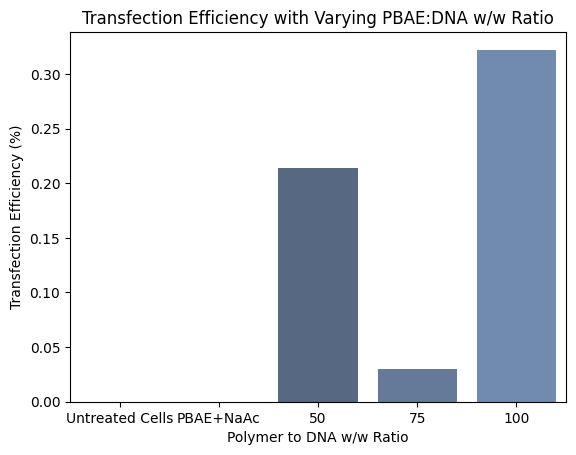

In [302]:
pei_things = ["C1","C2","C5","A2","A5",]
pbae_things = ["C1", "C3", "D4","B2","B4"]
pei_keys = ["Untreated Cells", "PEI+NaCl", "1", "2", "4"]
pbae_keys = ["Untreated Cells","PBAE+NaAc", "50", "75", "100"]
selected = cell_counts.loc[pei_things]
selected.index = pei_keys
sns.barplot(selected, x=pei_keys, y="viability", palette=sns.dark_palette("#8BF", n_colors=10)[2:7])
plt.ylabel("Viability (%)")
plt.xlabel(r"Polymer to DNA w/w Ratio")
plt.title("Cell Viability with Varying PEI:DNA w/w Ratio")
plt.show()

plt.figure()
sns.barplot(selected, x=pei_keys, y="efficacy", palette=sns.dark_palette("#8BF", n_colors=10)[2:7])
plt.ylabel("Transfection Efficiency (%)")
plt.xlabel(r"Polymer to DNA w/w Ratio")
plt.title("Transfection Efficiency with Varying PEI:DNA w/w Ratio")
plt.show()

selected = cell_counts.loc[pbae_things]
selected.index = pbae_keys
plt.figure()
sns.barplot(selected, x=pbae_keys, y="viability", palette=sns.dark_palette("#8BF", n_colors=10)[2:7])
plt.ylabel("Viability (%)")
plt.xlabel(r"Polymer to DNA w/w Ratio")
plt.title("Cell Viability with Varying PBAE:DNA w/w Ratio")
plt.show()

plt.figure()
sns.barplot(selected, x=pbae_keys, y="efficacy", palette=sns.dark_palette("#8BF", n_colors=10)[2:7])
plt.ylabel("Transfection Efficiency (%)")
plt.xlabel(r"Polymer to DNA w/w Ratio")
plt.title("Transfection Efficiency with Varying PBAE:DNA w/w Ratio")
plt.show()




18.0


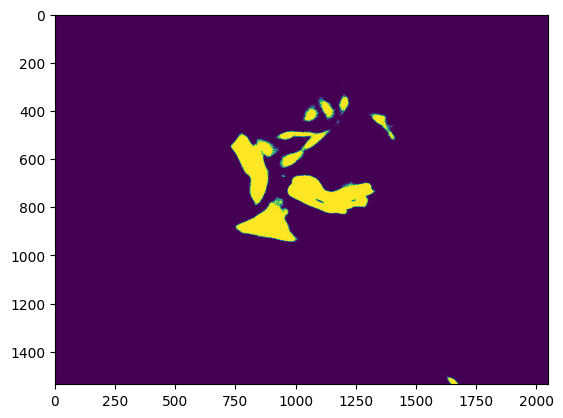

In [5]:
plt.imshow(gfp_mask)
print(th)

In [292]:
def cleanup(img, norm = False):
    new_img = median_filter(img)
    new_img = new_img - np.percentile(new_img.flatten(), 5)
    new_img = np.max(np.stack([new_img, np.zeros_like(new_img)], axis=0), axis=0).astype(np.uint8)
    if norm:
        new_img = new_img / np.percentile(new_img.flatten(), 95) * 255
        new_img = np.min(np.stack([new_img, np.ones_like(new_img) * 255], axis=0), axis=0).astype(np.uint8)
    return new_img


In [268]:
np.array(dapi.shape) / (64 * 8)

array([2.99609375, 3.99609375])

In [285]:
pei_things

['C1', 'C2', 'C5', 'A2', 'A5']

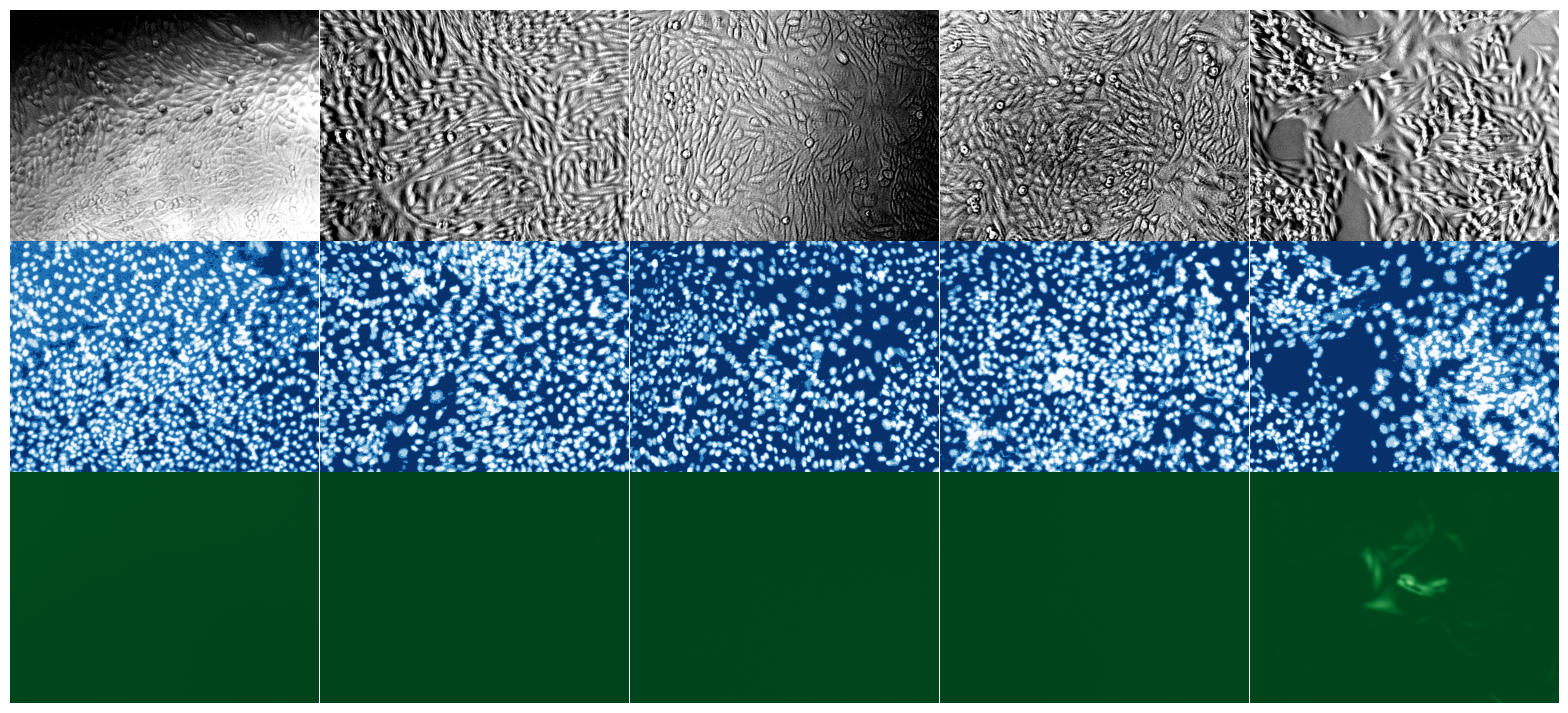

In [299]:
fig, ax = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(20, 9)
for i, thing in enumerate(pei_things):
    dapi = cv2.imread("GeneDelivery/{}_DAPI.jpg".format(thing), cv2.IMREAD_GRAYSCALE)
    dapi = cleanup(dapi, True)
    ax[1, i].set_axis_off()
    ax[1, i].imshow(dapi, cmap="Blues_r", vmin=0, vmax=255)
    gfp = cv2.imread("GeneDelivery/{}_GFP.jpg".format(thing), cv2.IMREAD_GRAYSCALE)
    gfp = cleanup(gfp)
    ax[2, i].set_axis_off()
    ax[2, i].imshow(gfp, cmap="Greens_r", vmin=0, vmax=255)
    trans = cv2.imread("GeneDelivery/{}_TRANS.jpg".format(thing), cv2.IMREAD_GRAYSCALE)
    trans = cleanup(trans, True)
    ax[0, i].set_axis_off()
    ax[0, i].imshow(trans, cmap="gray", vmin=0, vmax=255)
fig.subplots_adjust(wspace=0, hspace=0)

# fig.suptitle("Normalized Trans, DAPI, and GFP Filtered Microscopy Images")
# fig.supxlabel("Untreated, PEI+NaCl, 1, 2, 4 w/w Ratios")
# fig.supylabel("GFP, DAPI, Trans")
plt.savefig("PEI.png", bbox_inches="tight", transparent=True)
plt.show()


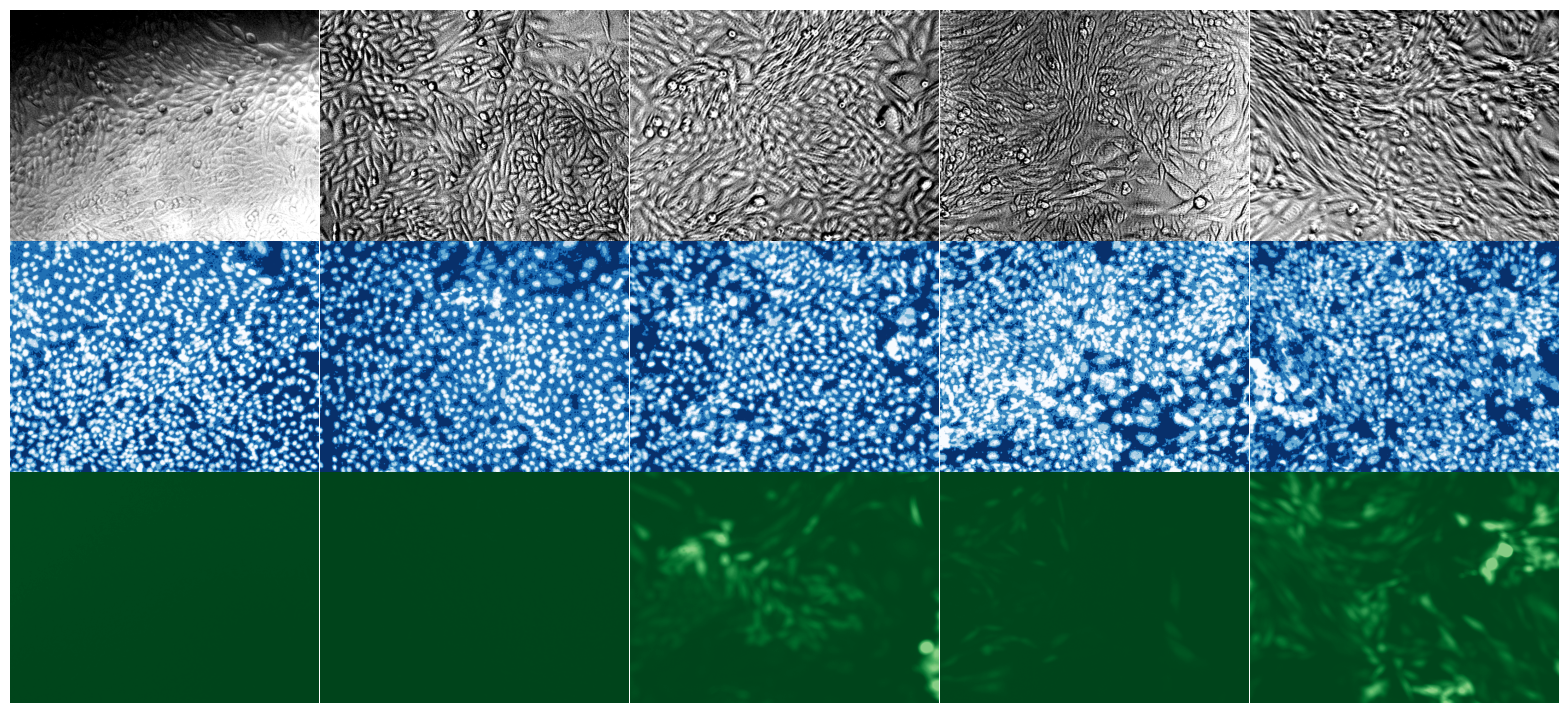

In [300]:
fig, ax = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(20, 9)
for i, thing in enumerate(pbae_things):
    dapi = cv2.imread("GeneDelivery/{}_DAPI.jpg".format(thing), cv2.IMREAD_GRAYSCALE)
    dapi = cleanup(dapi, True)
    ax[1, i].set_axis_off()
    ax[1, i].imshow(dapi, cmap="Blues_r", vmin=0, vmax=255)
    gfp = cv2.imread("GeneDelivery/{}_GFP.jpg".format(thing), cv2.IMREAD_GRAYSCALE)
    gfp = cleanup(gfp)
    ax[2, i].set_axis_off()
    ax[2, i].imshow(gfp, cmap="Greens_r", vmin=0, vmax=255)
    trans = cv2.imread("GeneDelivery/{}_TRANS.jpg".format(thing), cv2.IMREAD_GRAYSCALE)
    trans = cleanup(trans, True)
    ax[0, i].set_axis_off(),
    ax[0, i].imshow(trans, cmap="gray", vmin=0, vmax=255)
fig.subplots_adjust(wspace=0, hspace=0)

# fig.suptitle("Normalized Trans, DAPI, and GFP Filtered Microscopy Images")
# fig.supxlabel("Untreated, PEI+NaCl, 1, 2, 4 w/w Ratios")
# fig.supylabel("GFP, DAPI, Trans")
plt.savefig("PBAE.png", bbox_inches="tight", transparent=True, )
plt.show()

In [ ]:



# plt.figure(figsize=(10, 10))
# dapi = cv2.imread("GeneDelivery/A5_DAPI.jpg", cv2.IMREAD_GRAYSCALE)
# plt.imshow(dapi)
# plt.colorbar()

# th, img_thresh = cv2.threshold(dapi, 4, 15, cv2.THRESH_BINARY)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
# opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=1)
# close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

# cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# minimum_area = 200
# average_cell_area = 650
# connected_cell_area = 800
# cells = 0
# for c in cnts:
#     area = cv2.contourArea(c)
#     if area > minimum_area:
#         cv2.drawContours(dapi, [c], -1, (36,255,12), 2)
#         if area > connected_cell_area:
#             cells += math.ceil(area / average_cell_area)
#         else:
#             cells += 1
# print('Cells: {}'.format(cells))
# plt.figure()
# plt.imshow(close)
# plt.show()
# plt.figure()
# plt.imshow(dapi)
# plt.show()